# Лекция 1

```
- Введение в Машинное обучение, ИСП РАН (Весна 2025)
- Инструкторы: Александр Безносиков и Ко
```

<hr>

Содержание

- Примеры задач машинного обучения
    - Регрессия
    - Классификация
- Математическая постановка задачи обучения: сравнение
- Переобучение
    - Разные распределения на тренировочных и тестовых данных
    - Переусложненная модель
    - Регуляризация как борьба с переобучением

<hr>

In [39]:
import warnings
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from IPython.display import display
from matplotlib.colors import ListedColormap
from scipy.optimize import minimize
from sklearn.datasets import load_iris
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from tqdm import tqdm
import os

warnings.filterwarnings("ignore")

In [40]:
# %pip install "kaleido==0.1.*"

## Утилиты

In [41]:
ASSETS_PATH = "./assets/"

In [42]:
def set_seed(seed: int = 420):
    np.random.seed(seed)

In [43]:
def save_plt(name: str):
    plt.savefig(
        f"{os.path.join(ASSETS_PATH, name)}.svg",
        bbox_inches="tight",
        pad_inches=0.1,
        format="svg",
    )
    plt.savefig(
        f"{os.path.join(ASSETS_PATH, name)}_transparent.svg",
        bbox_inches="tight",
        pad_inches=0.1,
        format="svg",
        transparent=True,
    )
    return None


def save_plotly(name: str, fig: go.Figure, svg: bool = True, html: bool = True):
    if html:
        fig.write_html(f"{os.path.join(ASSETS_PATH, name)}.html")
    if svg:
        fig.update_layout(
            # title=None,
            margin=dict(l=20, r=20, t=50, b=20),
        )
        fig.write_image(f"{os.path.join(ASSETS_PATH, name)}.svg", format="svg")
    return None

## Примеры задач ML

### Регрессия

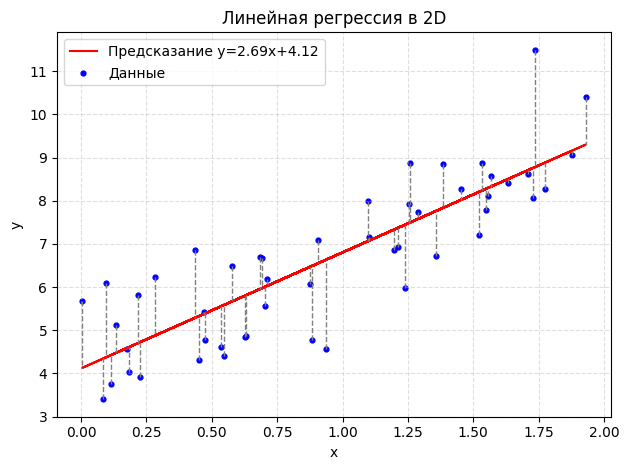

In [44]:
def plot_regression_2d(
    a: float,
    b: float,
    n: int = 50,
    noise_strength: float = 1,
    save_img: bool = False,
    seed: int = 420,
):
    set_seed(seed)

    # Генерируем данные
    X = 2 * np.random.rand(n, 1)
    y = a * X + b + noise_strength * np.random.randn(n, 1)

    # Обучаем модель
    model = LinearRegression()
    model.fit(X, y)

    # Предсказание
    y_pred = model.predict(X)
    a_pred = model.coef_[0][0]
    b_pred = model.intercept_[0]  # type: ignore

    # Строим график
    plt.plot(
        X,
        y_pred,
        color="red",
        label=f"Предсказание y={a_pred:.2f}x+{b_pred:.2f}",
        linewidth=1.5,
    )
    plt.scatter(X, y, color="blue", label="Данные", s=12)

    # Residuals
    for i in range(len(X)):
        plt.plot(
            [X[i], X[i]], [y[i], y_pred[i]], color="gray", linestyle="--", linewidth=1
        )

    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Линейная регрессия в 2D")
    plt.grid(alpha=0.4, linestyle="--")
    plt.legend()
    save_plt("linreg2d")
    plt.tight_layout()
    plt.show()


plot_regression_2d(a=3, b=4, save_img=True)

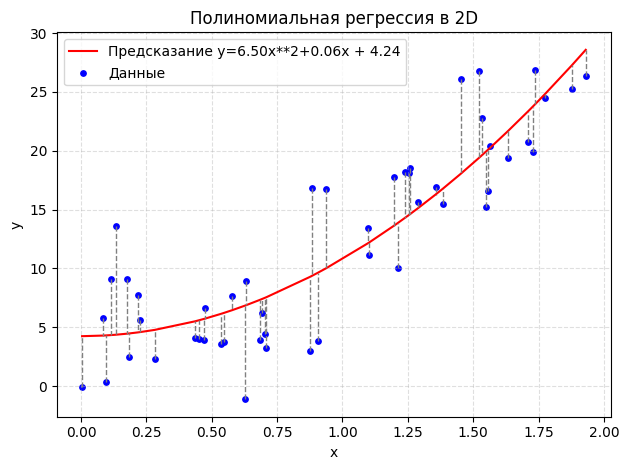

In [45]:
def plot_poly_regression_2d(
    a: float,
    b: float,
    c: float,
    n: int = 50,
    model_degree: int = 2,
    noise_strength: float = 4,
    save_img: bool = False,
    seed: int = 420,
):
    set_seed(seed)

    # Генерируем данные
    X = 2 * np.random.rand(n, 1)
    X = np.sort(X, axis=0)
    y = a * X**2 + b * X + c + noise_strength * np.random.randn(n, 1)

    # Обучаем модель
    model = make_pipeline(PolynomialFeatures(degree=model_degree), LinearRegression())
    model.fit(X, y)

    # Предсказание
    y_pred = model.predict(X)
    a_pred = model[1].coef_[0][2]
    b_pred = model[1].coef_[0][1]
    c_pred = model[1].intercept_[0]  # type: ignore

    # Строим график
    plt.plot(
        X,
        y_pred,
        color="red",
        label=f"Предсказание y={a_pred:.2f}x**2+{b_pred:.2f}x + {c_pred:.2f}",
        linewidth=1.5,
    )

    # Residuals
    for i in range(len(X)):
        plt.plot(
            [X[i], X[i]], [y[i], y_pred[i]], color="gray", linestyle="--", linewidth=1
        )

    plt.scatter(X, y, color="blue", label="Данные", s=15)

    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Полиномиальная регрессия в 2D")
    plt.grid(alpha=0.4, linestyle="--")
    plt.legend()
    save_plt("ployreg2d")
    plt.tight_layout()
    plt.show()


plot_poly_regression_2d(a=5, b=3, c=4, save_img=True)

In [46]:
def plot_regression_3d(
    a: float,
    b: float,
    c: float,
    n: int = 50,
    noise_strength: float = 4,
    save_img: bool = False,
    seed: int = 420,
):
    set_seed(seed)

    # Генерируем данные
    X = 4 * np.random.rand(n, 2)
    y = a * X[:, 1] + b * X[:, 0] + c + noise_strength * np.random.randn(n)

    # Обучаем модель
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Предсказание
    x0_grid, x1_grid = np.meshgrid(
        np.linspace(X[:, 0].min(), X[:, 0].max(), 20),
        np.linspace(X[:, 1].min(), X[:, 1].max(), 20),
    )
    X_grid = np.c_[x0_grid.ravel(), x1_grid.ravel()]
    y_grid_pred = model.predict(X_grid).reshape(x0_grid.shape)

    # Строим график
    fig = go.Figure()
    fig.add_trace(
        go.Scatter3d(
            x=X[:, 0],
            y=X[:, 1],
            z=y,
            mode="markers",
            marker={"size": 5, "color": "blue", "opacity": 0.7},
            name="Данные",
            showlegend=False,
        )
    )
    fig.add_trace(
        go.Surface(
            x=x0_grid,
            y=x1_grid,
            z=y_grid_pred,
            colorscale=[[0, "rgb(255,0,0)"], [1, "rgb(255,0,0)"]],
            opacity=0.2,
            name="Предсказание",
            showscale=False,
        )
    )

    # Residuals
    for i in range(len(X)):
        fig.add_trace(
            go.Scatter3d(
                x=[X[i, 0], X[i, 0]],
                y=[X[i, 1], X[i, 1]],
                z=[y[i], y_pred[i]],
                mode="lines",
                line={"color": "gray", "width": 4, "dash": "dash"},
                showlegend=False,
            )
        )

    fig.update_layout(
        title="Линейная регрессия в 3D",
        scene={"xaxis_title": "X1", "yaxis_title": "X2", "zaxis_title": "y"},
        scene_camera={
            "eye": {"x": -1, "y": -1.9, "z": 0.5}  # Позиция камеры
        },
        width=600,
        height=600,
        margin=dict(l=30, r=30, t=50, b=20),
    )

    fig.show()
    if save_img:
        save_plotly("linreg3d", fig)


plot_regression_3d(a=3, b=4, c=5, save_img=True)

### Классификация

In [47]:
def show_iris(save_img: bool = False, seed: int = 420):
    set_seed(seed)

    # Загружаем датасет Iris
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)  # type: ignore
    df["species"] = iris.target_names[iris.target]  # type: ignore

    print("Таблица с характеристиками цветов:")
    display(df.head(10))

    fig = px.scatter(
        df,
        x="sepal length (cm)",
        y="sepal width (cm)",
        color="species",
        title="Распределение признаков (чашелистики)",
        labels={
            "species": "Вид цветка",
            "sepal length (cm)": "Длина чашелистика (см)",
            "sepal width (cm)": "Ширина чашелистика (см)",
        },
        height=400,
        width=600,
    )
    fig.update_layout(
        margin=dict(l=30, r=35, t=50, b=30),
    )
    fig.show()
    if save_img:
        save_plotly("iris2d", fig)
    fig = px.scatter(
        df,
        x="petal length (cm)",
        y="petal width (cm)",
        color="species",
        title="Распределение признаков (лепестки)",
        labels={
            "species": "Вид цветка",
            "petal length (cm)": "Длина лепестка (см)",
            "petal width (cm)": "Ширина лепестка (см)",
        },
        height=400,
        width=600,
    )
    fig.update_layout(
        margin=dict(l=30, r=35, t=50, b=30),
    )
    fig.show()
    if save_img:
        save_plotly("iris2d2", fig)

    fig_3d = px.scatter_3d(
        df,
        x="sepal length (cm)",
        y="petal length (cm)",
        z="sepal width (cm)",
        color="species",
        title="Распределение признаков 3D",
        labels={
            "species": "Вид цветка",
            "sepal length (cm)": "Длина чашелистика (см)",
            "sepal width (cm)": "Ширина чашелистика (см)",
            "petal length (cm)": "Длина лепестка (см)",
        },
        height=400,
        width=600,
    )
    fig_3d.update_traces(marker_size=4)
    fig_3d.update_layout(
        margin=dict(l=30, r=35, t=40, b=30),
    )
    fig_3d.show()
    if save_img:
        save_plotly("iris3d", fig_3d)


show_iris(save_img=True)

Таблица с характеристиками цветов:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


<img width="300px" src="https://upload.wikimedia.org/wikipedia/ru/a/a6/%D0%A7%D0%B0%D1%88%D0%B5%D0%BB%D0%B8%D1%81%D1%82%D0%B8%D0%BA.jpg"/>
<img width="300px" src="https://upload.wikimedia.org/wikipedia/commons/7/78/Petal-sepal.jpg"/>

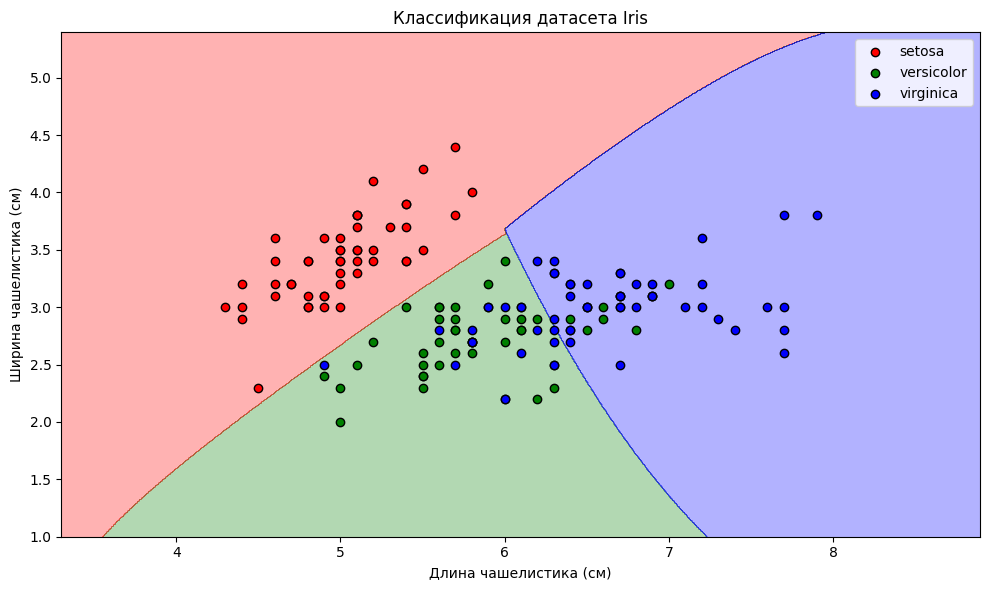

In [48]:
def plot_classification_iris(save_img: bool = False, seed: int = 420):
    set_seed(seed)

    # Загружаем датасет Iris
    iris = load_iris()
    X = iris.data  # type: ignore
    y = iris.target  # type: ignore

    # Используем только длину и ширину чашелистика
    X = X[:, :2]

    # Обучаем модель
    model = SVC(kernel="rbf", random_state=seed)
    model.fit(X, y)

    # Предсказание
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.005), np.arange(y_min, y_max, 0.005))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Построение графика
    plt.figure(figsize=(10, 6))
    colors = ["red", "green", "blue"]
    cmap = ListedColormap(colors)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)

    for i, color, target_name in zip([0, 1, 2], colors, iris.target_names):  # type: ignore
        plt.scatter(
            X[y == i, 0], X[y == i, 1], color=color, label=target_name, edgecolor="black"
        )

    plt.xlabel("Длина чашелистика (см)")
    plt.ylabel("Ширина чашелистика (см)")
    plt.title("Классификация датасета Iris")
    plt.legend(loc="upper right")
    if save_img:
        save_plt("iris_class")
    plt.tight_layout()
    plt.show()


plot_classification_iris(save_img=True)

## Математическая постановка задачи обучения: сравнение

Напомним, что мы хотим решить задачу (найти вектор $w^*$, дающий минимум $f$)
$$
\min_{w \in \mathbb{R}^d} f(w) := \mathbb{E}_{(x,y) \sim \mathcal{D}} \left[ \ell (g(x,w), y)\right]
$$

Но на деле решаем (находим $\hat w^*$ для $\hat f$)
$$
\min_{w \in \mathbb{R}^d} \hat f(w) := \frac{1}{n} \sum_{i=1}^n \ell (g(x_i,w), y_i)
$$

Насколько близки эти задачи? Ответ может дать

<div class="alert alert-block">
<b>Теорема</b>

Если функция $\ell (g(x,w), y)$ выпукла $M$-Липшицева по $w$, тогда с вероятностью хотя бы $1-\delta$
$$
	\begin{equation*}
	f(\hat{w}^*) - f(w^*) =  O\left(\sqrt{\frac{M^2 d\ln(n)\ln(\cfrac{d}{\delta})}{n}}\right).
	\end{equation*}
    $$
</div>


Для демонстрации теоремы, рассмотрим проблему минимизации эмпирического риска
$$
\begin{equation}
\min_{w \in \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n \ell (g(w, x_i), y_i),
\end{equation}
$$
где $\ell$ - функция ошибки, $g$ - модель, $w$ - параметры модели, $\{x_i, y_i\}_{i=1}^n$ набор данных состоящий из признаков $x_i$ и значений $y_i$, $\lambda > 0$ - параметр регуляризации

Будем использовать линейную модель $g(w, x) = w^T x$ и логистическую (сигмоидальную) функцию ошибки: $\ell(z,y) = \ln (1 + \exp(-yz))$ (**Важно: $y$ должны принимать значения -1 или +1**). Получившуюся задачу обычно называют задачей логистической регрессией

Можно показать, что задача является $M$-Липшецевой градиент, с $M = 1$

In [49]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def log_loss(w: np.ndarray, x: np.ndarray, y: np.ndarray) -> float:
    return np.mean(np.log(1 + np.exp(-y * x.dot(w))))


def approximation_errors(
    n_values,
    n_total: int = 1000,
    dim: int = 10,
    n_experiments: int = 20,
    noise_strength: float = 1.0,
    maxiter: int = 10,
    seed: int = 420,
) -> list[float]:
    set_seed(seed)

    # Генерируем данные
    x = 100 * np.random.rand(n_total, dim)
    w_true = 50 * np.random.rand(dim)
    y = (
        sigmoid(x.dot(w_true) + noise_strength * np.random.randn(n_total)) - 1e-8
    )  # y в промежутке от 0 до 1

    # Сделаем y -1 или 1
    y = np.trunc(y * 2)  # y теперь 0 или 1
    y = y * 2 - 1  # y теперь -1 или 1

    # Посчитаем оптимальное значение ошибки
    f_star = log_loss(w_true, x, y)

    w0 = np.random.randn(*w_true.shape)  # Стартовая точка для минимизации

    # Проведение экспериментов
    errors = []
    for n in tqdm(n_values):
        errors_inner = []
        for _ in range(n_experiments):
            # Перемешиваем данные
            indices = list(range(len(y)))
            np.random.shuffle(indices)
            indices = indices[:n]
            x_experiment, y_experiment = x[indices, :].squeeze(), y[indices].squeeze()

            w_hat = minimize(
                partial(log_loss, x=x_experiment, y=y_experiment),
                w0,
                options={"maxiter": maxiter},
            ).x.squeeze()

            # Вычисление ошибки на всех данных
            errors_inner.append(log_loss(w_hat, x=x, y=y) - f_star)

        # Средняя ошибка по всем экспериментам
        errors.append(np.mean(errors_inner))

    return errors


approx_n = 5000
approx_ns = np.arange(100, 4001, 100)
approx_dim = 20

approx_errors = approximation_errors(approx_ns, n_total=approx_n, dim=approx_dim)

100%|██████████| 40/40 [00:11<00:00,  3.37it/s]


In [50]:
def theoretical_bound(delta: float, n: int, M: float = 1, dim: int = approx_dim):
    return np.sqrt((M**2 * dim * np.log(n) * np.log(dim / delta)) / n)


def plot_error_approx(
    n_values, errors: list[float], save_img: bool = False, seed: int = 420
):
    set_seed(seed)

    fig = go.Figure()

    # График ошибки
    fig.add_trace(
        go.Scatter(
            x=n_values,
            y=errors,
            mode="lines+markers",
            name="Ошибка",
        )
    )

    fig.update_layout(
        title="Зависимость ошибки от размера выборки n",
        xaxis_title="n, размер выборки",
        yaxis_title="Ошибка, логарифмическая шкала",
        showlegend=True,
        margin=dict(l=30, r=35, t=50, b=30),
    )
    fig.update_yaxes(type="log")

    if save_img:
        save_plotly("theorem", fig, html=False)

    # Теоретические оценки
    deltas = np.linspace(1e-3, 1 - 1e-3, 20)
    steps = []
    for delta in deltas:
        theoretical_values = [theoretical_bound(delta, n) for n in n_values]
        fig.add_trace(
            go.Scatter(
                x=n_values,
                y=theoretical_values,
                mode="lines",
                name=f"Оценка теоремы δ={delta:.3f}",
                visible=False,
            )
        )

    # Настроим видимость графиков
    for i in range(len(deltas)):
        step = {
            "method": "update",
            "args": [{"visible": [True] + [False] * len(deltas)}],
            "label": f"{deltas[i]:.3f}",
        }
        step["args"][0]["visible"][i + 1] = True  # type: ignore
        steps.append(step)

    # Добавляем ползунок
    sliders = [
        {"active": 0, "currentvalue": {"prefix": "δ: "}, "pad": {"t": 50}, "steps": steps}
    ]

    fig.update_layout(
        sliders=sliders,
        margin=dict(l=30, r=35, t=50, b=30),
    )

    # Показываем график
    fig.show()

    if save_img:
        save_plotly("theorem", fig, svg=False)


plot_error_approx(approx_ns, approx_errors, save_img=True)

## Переобучение

In [51]:
def true_function_overfitting(x: np.ndarray):
    return np.sin(x)


def generate_data_overfitting(
    n_samples: int = 100,
    noise: float = 0.1,
    bias_ratio: float = 0.8,
    start: float = -3,
    stop: float = 3,
    seed: int = 420,
):
    set_seed(seed)
    X = np.random.uniform(start, stop, size=n_samples)
    y = true_function_overfitting(X) + np.random.normal(0, noise, size=n_samples)

    # Создаем перекос в данных
    bias_samples = int(n_samples * bias_ratio)
    X[:bias_samples] = np.random.uniform(0, stop, size=bias_samples)
    y[:bias_samples] = true_function_overfitting(X[:bias_samples]) + np.random.normal(
        0, noise, size=bias_samples
    )

    return X.reshape(-1, 1), y


def show_overfitting(
    save_img: bool = False,
    seed: int = 420,
    overfitting_degree: int = 15,
    regularization: float = 2.0,
    start: float = -3,
    stop: float = 3,
):
    # Генерируем данные с "перекосом" в тренировочных и тестовых данных
    X_train, y_train = generate_data_overfitting(
        n_samples=90, noise=0.1, bias_ratio=0.85, start=start, stop=stop, seed=seed
    )
    X_test, y_test = generate_data_overfitting(
        n_samples=30, noise=0.1, bias_ratio=0.1, start=start, stop=stop, seed=seed
    )

    # 1. Линейная регрессия (недообучение)
    model_linear = LinearRegression()
    model_linear.fit(X_train, y_train)
    model_linear.predict(X_test)

    # 2. Полиномиальная регрессия высокой степени (переобучение)
    model_poly = make_pipeline(
        PolynomialFeatures(degree=overfitting_degree), LinearRegression()
    )
    model_poly.fit(X_train, y_train)
    model_poly.predict(X_test)

    # 3. Полиномиальная регрессия с регуляризацией (борьба с переобучением)
    model_poly_ridge = make_pipeline(
        PolynomialFeatures(degree=overfitting_degree), Ridge(alpha=regularization)
    )
    model_poly_ridge.fit(X_train, y_train)

    # Визуализация
    X_plot = np.linspace(start, stop, 100).reshape(-1, 1)
    y_true = true_function_overfitting(X_plot)

    fig = go.Figure(layout=go.Layout(yaxis={"range": [-2, 2]}))
    fig.add_trace(
        go.Scatter(
            x=X_train.flatten(),
            y=y_train,
            mode="markers",
            name="Тренировочные данные",
            marker={"color": "blue"},
        )
    )
    fig.add_trace(
        go.Scatter(
            x=X_test.flatten(),
            y=y_test,
            mode="markers",
            name="Тестовые данные",
            marker={"color": "red"},
        )
    )
    fig.add_trace(
        go.Scatter(
            x=X_plot.flatten(),
            y=model_linear.predict(X_plot),
            mode="lines",
            name="Линейная модель",
            line={"dash": "dash", "color": "green"},
        )
    )
    fig.add_trace(
        go.Scatter(
            x=X_plot.flatten(),
            y=model_poly.predict(X_plot),
            mode="lines",
            name=f"Полиномиальная модель степени {overfitting_degree}",
            line={"dash": "dash", "color": "orange"},
        )
    )
    fig.add_trace(
        go.Scatter(
            x=X_plot.flatten(),
            y=model_poly_ridge.predict(X_plot),
            mode="lines",
            name="Полиномиальная модель с регуляризацией",
            line={"dash": "dash", "color": "purple"},
        )
    )
    fig.add_trace(
        go.Scatter(
            x=X_plot.flatten(),
            y=y_true.flatten(),
            mode="lines",
            name="Реальная функция",
            line={"color": "black"},
        )
    )

    fig.update_layout(
        title="Проблема переобучения",
        legend={
            "orientation": "h",
            "yanchor": "bottom",
            "y": 1.02,
            "xanchor": "right",
            "x": 1,
        },
        xaxis_title="X",
        yaxis_title="y",
        width=900,
        height=600,
        margin=dict(l=30, r=35, t=50, b=30),
    )
    fig.show()

    if save_img:
        save_plotly("overfitting", fig)


show_overfitting(save_img=True)